In [1]:
import gym
from gym import spaces
import pygame
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

pygame 2.0.2 (SDL 2.0.16, Python 3.8.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
BLOCKS_PATTERN1 = set({
    (3, 0),
    (3, 1),
    (3, 2),
    (3, 3),
    (3, 4),
    (3, 5),
    (3, 6),
    (3, 7),
    
})

BLOCKS_PATTERN2 = set({

    
    (3, 1),
    (3, 2),
    (3, 3),
    (3, 4),
    (3, 5),
    (3, 6),
    (3, 7),
    (3, 8)
    
})


In [3]:
class MazeEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps":4}
    def __init__(self, render_mode=None, size=(7,9), start=(0,4), goal=(6,8), blocks=BLOCKS_PATTERN1):
        
        
        self.start = np.array(start)
        self.goal = np.array(goal)
        self.blocks = blocks
        
        self.size = size
        
        
        self.window_size = ((1024/7)*9, 1024)
        
        


        self.observation_space = spaces.Tuple((spaces.Box(low=0, high = size[0] - 1, shape=(1,), dtype=int), 
                                               spaces.Box(low=0, high = size[1] - 1, shape=(1,), dtype=int)))


        
        self.action_space = spaces.Discrete(4)
        self.nS = 2* (size[0]*size[1])
        self.nA = 4

        # up, right, down, left (arangement distribution (nth row, nth col) rather than representational (x,y))
        self._action_to_direction = {
            0: np.array([1,0]),
            1: np.array([0,1]),
            2: np.array([-1,0]),
            3: np.array([0,-1]),
        }
        
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode
        self.window = None
        self.clock = None

        self.agent_image = pygame.image.load("r2d2.png") 
        self.agent_image = pygame.transform.scale(self.agent_image, (self.window_size[0]/size[1],self.window_size[1]/size[0]))
        self.agent_rect = self.agent_image.get_rect()
    
        
        self.cheeze_image = pygame.image.load("cheeze.png") 
        self.cheeze_image = pygame.transform.scale(self.cheeze_image, (self.window_size[0]/size[1],self.window_size[1]/size[0]))
        self.cheeze_rect = self.cheeze_image.get_rect()
        
    
    def _get_obs(self):

        return self._agent_location
    
    def _get_info(self):

        return {"distance": np.linalg.norm(self._agent_location - self.goal, ord=1)}
    
    def reset(self, seed = None, options = None):

    
        self._agent_location = self.start
                   
        observation = self._get_obs()
        info = self._get_info()
        
        if self.render_mode == "human":
            self._render_frame()
            
        return observation, info
    
    def step(self, action):
        direction = self._action_to_direction[action]
        
        
        
        new_position = np.clip(
        self._agent_location + direction, (0, 0) , (self.size[0]-1, self.size[1]-1) )
        
        is_blocked = tuple(new_position) in self.blocks
        
        self._agent_location = new_position if not is_blocked else self._agent_location 
        
        terminated = np.array_equal(self._agent_location, self.goal)
        
#         rewards are sparse (u get 1 when u reach target else u get 0), its called binary sparse rewards lol

        reward = 1 if terminated else 0
    
        observation = self._get_obs()
        
        info = self._get_info()
        
        if self.render_mode == "human":
            self._render_frame()
        
        return observation, reward, terminated,False, info
    
    def render(self):
        if self.render_mode =="rgb_array":
            return self._render_frame()
    
    def _get_pixel_point(self, coord):
        
        n_rows = self.size[0]
        n_cols = self.size[1]
        y = coord[0]
        x = coord[1]
        W = self.window_size[0]/n_cols
        H = self.window_size[1]/n_rows

        d_from_top = (n_rows- 1-y)*H
        d_from_left = (x)*W
        
        return (d_from_left, d_from_top)

  

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode(self.window_size)
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface(self.window_size)
        canvas.fill((255, 255, 255))
        
        # pixel_size = width X Height == (size[1], size[0]) == ncols , nrows
        pix_square_size = ( self.window_size[0] / self.size[1], self.window_size[1] / self.size[0])
        

        # First we draw the goal
        # px=self._get_pixel_point(self.goal)
        # pygame.draw.rect(
        #     canvas,
        #     (0, 70, 255),
        #     pygame.Rect(

        #         px,
        #         (pix_square_size[0], pix_square_size[1]),
        #     ),
        # )
        # Now we draw the agent
        self.agent_rect.x , self.agent_rect.y = self._get_pixel_point(self._agent_location)
        self.cheeze_rect.x,self.cheeze_rect.y = self._get_pixel_point(self.goal)

        # horizontal lines
        for x in range(self.size[1] + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size[1] * x),
                (self.window_size[0], pix_square_size[1] * x),
                width=3,
            )
        # vertical lines
        for x in range(self.size[1] + 1):
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size[1] * x, 0),
                (pix_square_size[1] * x, self.window_size[1]),
                width=3,
            )
        
        images=[]
        image_rects = []

        for x,y in self.blocks:
            wall_image = pygame.image.load("wall.png") 
            wall_image = pygame.transform.scale(wall_image, (self.window_size[0]/self.size[1],self.window_size[1]/self.size[0]))
            wall_rect= wall_image.get_rect()
            wall_rect.x , wall_rect.y = self._get_pixel_point((x,y))
            canvas.blit(wall_image, wall_rect)

        canvas.blit(self.agent_image, self.agent_rect)
        canvas.blit(self.cheeze_image, self.cheeze_rect)

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )




In [4]:
env_first = MazeEnv(blocks = BLOCKS_PATTERN1, start=(0,3))
env_second = MazeEnv(blocks = BLOCKS_PATTERN2,start=(0,3))

# Dyna Q

In [5]:
def initialize_times(nS, nA):
#     
    indices = np.indices((7,9))
    keys = np.stack(indices, axis=-1).reshape((-1,2))
#     Q = {tuple(key): np.random.normal(0.5, 0.25, (nA,)) for key in keys}
    Q = {tuple(key): np.zeros((nA, )) for key in keys}
    
    
    return Q

In [6]:
def initializer(nS, nA):
#     
    indices = np.indices((7,9))
    keys = np.stack(indices, axis=-1).reshape((-1,2))
#     Q = {tuple(key): np.random.normal(0.5, 0.25, (nA,)) for key in keys}
    Q = {tuple(key): np.zeros((nA,)) for key in keys}
    Q[(6,8)] = np.zeros((nA,))
    return Q

In [7]:
class QControl:
    def __init__(self, nS, nA, terminal=list((6,8)), eps=None, initializer=None, gamma = 1.0):
        self.Q = np.random.normal(0.5,0.25, (nS, nA) )

        
        if initializer!=None:
            self.Q = initializer(nS, nA)
        
        
        for i in terminal:
            self.Q[i] = np.array([0, 0])
        
        self.pi = np.random.randint(0, 4, (16, ), dtype=np.int8)
        self.alpha = 0.2
        self.gamma = gamma
        self.epsilon = eps
        self.last_action = 0
    
    def policy(self, state, eps=None):
        
        if eps == None:
            if self.epsilon != None:
                eps = self.epsilon
            else:
                eps = 0.2
        
        
        if np.random.random() >= eps:
            return np.argmax(self.Q[state])
        else:
            return np.random.randint(0, 4)
        
    def learn(self, s, env, step_size, eps=None):
        if eps == None:
            if self.epsilon != None:
                eps = self.epsilon
            else:
                eps = 0.1
        a = self.policy(s, eps=eps)
        s_, r, done, _, info = env.step(a)
        
        s_ = tuple(s_)
        self.Q[s][a] = self.Q[s][a] + step_size*(r + self.gamma*np.max(self.Q[s_]) - self.Q[s][a] )
        
        self.last_action = a
        
        return s_, r, done,_, info
    
    def plan(self, s, model, step_size,a,  eps=None):
        
                
        r, s_ = model[(s,a)]
        self.Q[s][a] = self.Q[s][a] + step_size*(r + self.gamma*np.max(self.Q[s_]) - self.Q[s][a]   )
        self.last_action = a
        return s_, r, False, {}
    
    def load_q_values(self, file_location):
        f = open(file_location, "rb")
        self.Q = pickle.load(f)

In [8]:
def dynaQTest(QControl, env,env2, planning_steps,  step_size=0.5, episode_limit = 500, Q = None, eps = 0.2, gamma = 0.95):
#     
    q_control = QControl(env.nS, env.nA, eps=eps, terminal=[], initializer=initializer, gamma = gamma)
    model = {}
    
    Times = initialize_times(env.nS, env.nA)
    
    if Q is not None:
        q_control.Q = Q
    
    observed_states = set({})
    
    indices = np.indices((7,9))
    keys = np.stack(indices, axis=-1).reshape((-1,2))

    observed_actions = {tuple(key):set() for key in keys}
    curr_s = env.reset()[0]
    
    cum = []
    cum_r = 0
    
    rewards = []
    Rs= 0
    
    
    done = False
    curr_s = tuple(env.reset()[0])

    for t in range(episode_limit):

        if done:
            env.reset()
            done = False
        s_, r, done, _,info = q_control.learn(curr_s, env, step_size)
        
        s_ = tuple(s_)
        a = q_control.last_action
        Times[curr_s][a] = t
        
        model[curr_s, a] = [r, s_]


        observed_actions[curr_s].add(a)
        observed_states.add(curr_s)
        curr_s = s_
        Rs+=r
        cum_r+=r

        cum.append(cum_r)
        




        for n in range(planning_steps):
            states = list(observed_states)
            s = np.random.choice(np.arange(len(states)))
            actions = list(observed_actions[states[s]])

            a = np.random.choice(actions)



            
            q_control.plan(states[s], model, step_size, a)
        
        rewards.append(Rs)
        if t == 1000:
            env.blocks = env_second.blocks
    return rewards, q_control, cum, Times

    

In [9]:
qcontrol.Q is None

NameError: name 'qcontrol' is not defined

In [1180]:
accumulated_avg = []
for i in tqdm(range(15)):
    rs0, qcontrol, cum0, Times = dynaQTest(QControl, env_first,env_second, 100, step_size=0.1, episode_limit=3000, eps=0.1, gamma = 0.95)
    accumulated_avg.append(cum0)
                          

100%|████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:47<00:00,  7.18s/it]


In [1181]:
accumulated_avg = list(np.mean(accumulated_avg, axis=0))

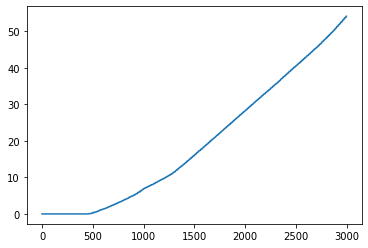

In [1182]:
plt.plot(accumulated_avg)


In [1109]:
save(qcontrol.Q, name="DynaQ_before _change.pkl")
save(qcontrol_1.Q, name="DynaQ_after_change.pkl")

In [ ]:
def load(s):
    with open(s, "rb") as f:
        return pickle.load(f)
    return None

In [231]:
def demo_policy(control, limit=30):
    env.reset()
#     out = env.render(mode="ansi")
    done = False
    s = env.reset()
    s = tuple([*s[0]["agent"], *s[0]["target"] ])
    i = 0
    while not done:
        
        s_, r, done, prop, _ = env.step(np.argmax(control.Q[s]))
        
        env.render()
        s_ = tuple([*s_["agent"], *s_["target"] ])
        s = s_
        i+=1
        if done:
            print("congrats")
        if i >= limit:
            done = True
            

In [439]:
import pickle
def save(Q, name="DynaQ_blocks1.pkl"):
    with open(name, "wb") as f:
        pickle.dump(Q, f)

In [333]:
with open("dynaQ_2.pkl", "wb") as f:
        pickle.dump(qcontrol.Q, f)

In [331]:
save(qcontrol.Q, name="DynaQ_blocks1_2.pkl")


'name=DynaQ_blocks1_2.pkl)' was not found in history, as a file, url, nor in the user namespace.


# DynaQ+

In [1183]:
def dynaQPlusTest(QControl, env, env2, planning_steps,  step_size=0.5, episode_limit = 500, Q = None, eps = 0.2, k = 0.1, gamma = 0.95):
#     
    q_control = QControl(env.nS, env.nA, eps=eps, terminal=[], initializer=initializer, gamma = gamma)
    model = {}
    
    Times = initialize_times(env.nS, env.nA)
    
    if Q is not None:
        q_control.Q = Q
    
    observed_states = set({})
    
    indices = np.indices((7,9))
    keys = np.stack(indices, axis=-1).reshape((-1,2))

    observed_actions = {tuple(key):set() for key in keys}
    curr_s = env.reset()[0]
    
    cum = []
    cum_r = 0
    
    rewards = []
    Rs= 0
    
    
    done = False
    curr_s = tuple(env.reset()[0])

    for t in range(episode_limit):

        if done:
            env.reset()
            done = False
        s_, r, done, _,info = q_control.learn(curr_s, env, step_size)
        
        s_ = tuple(s_)
        a = q_control.last_action
        Times[curr_s][a] = t
        
        model[curr_s, a] = [r, s_]


        observed_actions[curr_s].add(a)
        observed_states.add(curr_s)
        curr_s = s_
        Rs+=r
        cum_r+=r

        cum.append(cum_r)
        




        for n in range(planning_steps):
            states = list(observed_states)

            s = np.random.choice(np.arange(len(states)))
            actions = list(observed_actions[states[s]])

            a = np.random.choice(actions)
            
                
            
            q_control.plan(states[s], model, step_size, a)
            a_ = q_control.last_action
#             Tau = time elapsed since the last time s,a was used in learning
            Tau = t - Times[states[s]][a]
            
            q_control.Q[states[s]][a] += np.sqrt(Tau)*k
        
            

        rewards.append(Rs)
        
        if t == 1000:
            env.blocks = env2.blocks
    return rewards, q_control, cum, Times

    

In [1184]:
k = 0.0003
accumulated_avg_plus_0 = []
Times = []
for i in tqdm(range(15)):
    
    rs_plus_0, qcontrol_plus_0, cum_plus_0, Times_plus_0 = dynaQPlusTest(QControl, env_first,env_second, 100, step_size=0.1, episode_limit=3000, eps=0.1, k = k, gamma =0.95)
    accumulated_avg_plus_0.append(cum_plus_0)
    Times.append(Times_plus_0)
accumulated_avg_plus_0 = list(np.mean(accumulated_avg_plus_0, axis=0))


100%|████████████████████████████████████████████████████████████████████████████████████| 15/15 [02:03<00:00,  8.24s/it]


In [1112]:
save(qcontrol_plus_0.Q, name="DynaQ+_before_change.pkl")
save(qcontrol_plus_1.Q, name="DynaQ+_after_change.pkl")

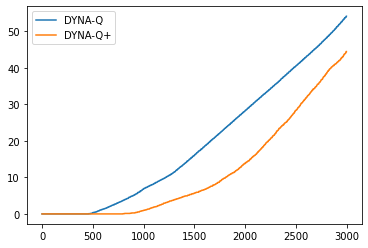

In [1185]:
plt.plot(accumulated_avg , label="DYNA-Q")
plt.plot(accumulated_avg_plus_0 , label="DYNA-Q+")
plt.legend()

# Shortcut maze

In [10]:
SHORTCUT_PATTERN_1 = set({
    
    (3, 1),
    (3, 2),
    (3, 3),
    (3, 4),
    (3, 5),
    (3, 6),
    (3, 7),
    (3,8)
    
})

SHORTCUT_PATTERN_2 = set({

    (3, 1),
    (3, 2),
    (3, 3),
    (3, 4),
    (3, 5),
    (3, 6),
    (3, 7),
    
})

In [273]:
env_s1 = MazeEnv(blocks = SHORTCUT_PATTERN_1, start=(0,3))
env_s2 = MazeEnv(blocks = SHORTCUT_PATTERN_2,start=(0,3))

In [1160]:
def dynaQTest2(QControl, env, env2, planning_steps,  step_size=0.5, episode_limit = 6000, Q = None, eps = 0.2, gamma = 0.95):
#     
    q_control = QControl(env.nS, env.nA, eps=eps, terminal=[], initializer=initializer, gamma = gamma)
    model = {}
    
    Times = initialize_times(env.nS, env.nA)
    
    if Q is not None:
        q_control.Q = Q
    
    observed_states = set({})
    
    indices = np.indices((7,9))
    keys = np.stack(indices, axis=-1).reshape((-1,2))

    observed_actions = {tuple(key):set() for key in keys}
    curr_s = env.reset()[0]
    
    cum = []
    cum_r = 0
    
    rewards = []
    Rs= 0
    
    
    done = False
    curr_s = tuple(env.reset()[0])

    for t in range(episode_limit):

        if done:
            env.reset()
            done = False
        s_, r, done, _,info = q_control.learn(curr_s, env, step_size)
        
        s_ = tuple(s_)
        a = q_control.last_action
        Times[curr_s][a] = t
        
        model[curr_s, a] = [r, s_]


        observed_actions[curr_s].add(a)
        observed_states.add(curr_s)
        curr_s = s_
        Rs+=r
        cum_r+=r

        cum.append(cum_r)
        




        for n in range(planning_steps):
            states = list(observed_states)
            s = np.random.choice(np.arange(len(states)))
            actions = list(observed_actions[states[s]])

            a = np.random.choice(actions)



            
            q_control.plan(states[s], model, step_size, a)
        
        
        rewards.append(Rs)
        
        if t == 3000:
            env = env2
            env.blocks = env2.blocks
            
    return rewards, q_control, cum, Times

    

In [1154]:
def dynaQPlusTest2(QControl, env,env2, planning_steps,  step_size=0.5, episode_limit = 500, Q = None, eps = 0.2, k = 0.1, gamma = 0.95):
#     
    q_control = QControl(env.nS, env.nA, eps=eps, terminal=[], initializer=initializer, gamma = gamma)
    model = {}
    
    Times = initialize_times(env.nS, env.nA)
    
    if Q is not None:
        q_control.Q = Q
    
    observed_states = set({})
    
    indices = np.indices((7,9))
    keys = np.stack(indices, axis=-1).reshape((-1,2))

    observed_actions = {tuple(key):set() for key in keys}
    curr_s = env.reset()[0]
    
    cum = []
    cum_r = 0
    
    rewards = []
    Rs= 0
    
    
    done = False
    curr_s = tuple(env.reset()[0])

    for t in range(episode_limit):

        if done:
            env.reset()
            done = False
        s_, r, done, _,info = q_control.learn(curr_s, env, step_size)
        
        s_ = tuple(s_)
        a = q_control.last_action
        Times[curr_s][a] = t
        
        model[curr_s, a] = [r, s_]


        observed_actions[curr_s].add(a)
        observed_states.add(curr_s)
        curr_s = s_
        Rs+=r
        cum_r+=r

        cum.append(cum_r)
        




        for n in range(planning_steps):
            states = list(observed_states)

            s = np.random.choice(np.arange(len(states)))
            actions = list(observed_actions[states[s]])

            a = np.random.choice(actions)
            
                
            
            q_control.plan(states[s], model, step_size, a)
            a_ = q_control.last_action
#             Tau = time elapsed since the last time s,a was used in learning
            Tau = t - Times[states[s]][a]
            
            q_control.Q[states[s]][a] += np.sqrt(Tau)*k
            
        

        rewards.append(Rs)
        
        if t == 3000:
            env.blocks = env2.blocks
    return rewards, q_control, cum, Times

    

# dynaQ

In [1161]:

accumulated_shortcut_0 = []
Times = []
for i in tqdm(range(15)):
    
    rs_0_, qcontrol_0_, cum_0_, Times_0_ = dynaQTest2(QControl, env_s1,env_s2,100, step_size=0.1, episode_limit=6000, eps=0.1, gamma =0.95)
    
    accumulated_shortcut_0.append(cum_0_)
    Times.append(Times_0_)
accumulated_shortcut_0 = list(np.mean(accumulated_shortcut_0, axis=0))

# 2nd env
q_control_short_before = qcontrol_0_



100%|████████████████████████████████████████████████████████████████████████████████████| 15/15 [03:23<00:00, 13.60s/it]


In [1156]:
save(q_control_short_before.Q, name="DynaQ_shortcut_before.pkl")
save(q_control_short_after.Q, name="DynaQ_shortcut_after.pkl")

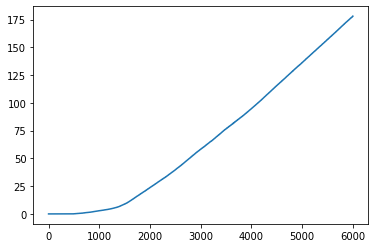

In [1162]:
plt.plot(accumulated_shortcut_0)

# dynaQ+

In [1175]:
k = 0.0003
accumulated_shortcut_1 = []
Times = []
for i in tqdm(range(15)):
    
    rs_1_, qcontrol_1_, cum_1_, Times_1_ = dynaQPlusTest2(QControl, env_s1,env_s2,100, step_size=0.1, episode_limit=6000, eps=0.1, gamma =0.95, k=k)
    
    accumulated_shortcut_1.append(cum_1_)
    Times.append(Times_1_)
accumulated_shortcut_1 = list(np.mean(accumulated_shortcut_1, axis=0))

# 2nd env
q_control_short_plus = qcontrol_1_



100%|████████████████████████████████████████████████████████████████████████████████████| 15/15 [06:34<00:00, 26.28s/it]


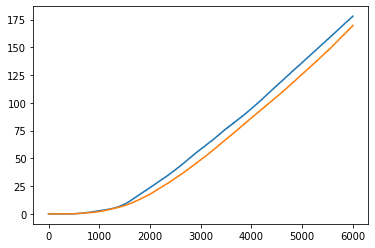

In [1177]:
plt.plot(accumulated_shortcut_0)
plt.plot(accumulated_shortcut_1)

In [1178]:
save(qcontrol_0_.Q, name="DynaQ_shortcut_plus.pkl")
save(qcontrol_1_.Q, name="DynaQ+_shortcut_plus.pkl")

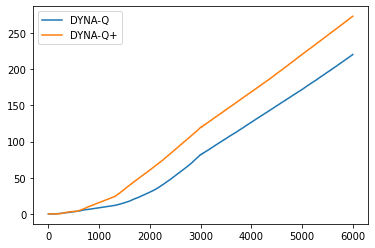

In [1128]:
plt.plot(accumulated_shortcut_0+list( np.array(accumulated_shortcut_1)+accumulated_shortcut_0[-1]) , label="DYNA-Q")
plt.plot(accumulated_shortcut_plus_0+list( np.array(accumulated_shortcut_plus_1)+accumulated_shortcut_plus_0[-1]) , label="DYNA-Q+")
plt.legend()

# Playing around with times

In [977]:
images = []
for i in range(len(Times)):
    img = np.zeros( (7,9))
    max_val = np.max(list(Times[i].values()))
    for state in Times[i]:

        img[state[0], state[1]] = sum(Times[i][state])/len(Times)

    images.append(img)

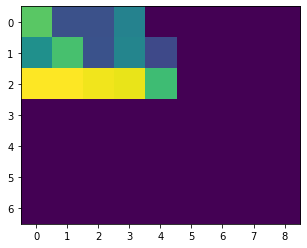

In [978]:
plt.imshow(images[1])

In [979]:
from matplotlib import animation

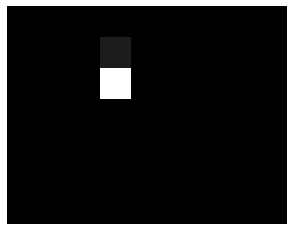

In [980]:
fig, ax = plt.subplots()

def update(i):
    ax.imshow(images[i], cmap="gray")  # Set image for current frame
    ax.axis('off')  # Hide axis

# Create animation object
ani = animation.FuncAnimation(fig, update, frames=len(images), interval=50)

# Save animation as video file
ani.save('my_video.mp4', writer='ffmpeg')

# Prioritized Sweeping

In [981]:
!explorer .


In [415]:
def dynaQBasic(QControl, env, planning_steps,  step_size=0.5, episode_limit = 500, Q = None, eps = 0.2, gamma = 0.95):
#     
    EVALUATION_RECORD = [False]*(10)
    eval_stats = []
    
    q_control = QControl(env.nS, env.nA, eps=eps, terminal=[], initializer=initializer, gamma = gamma)
    model = {}
    
    Times = initialize_times(env.nS, env.nA)
    
    if Q is not None:
        q_control.Q = Q
    
    observed_states = set({})
    
    indices = np.indices((7,9))
    keys = np.stack(indices, axis=-1).reshape((-1,2))

    observed_actions = {tuple(key):set() for key in keys}
    curr_s = env.reset()[0]
    
    cum = []
    cum_r = 0
    
    rewards = []
    Rs= 0
    
    
    done = False
    curr_s = tuple(env.reset()[0])
    
    reached_optimality = False
    n_updates = True
    
    for t in range(episode_limit):

        if done:
            env.reset()
            done = False
        s_, r, done, _,info = q_control.learn(curr_s, env, step_size)
        
        s_ = tuple(s_)
        a = q_control.last_action
        Times[curr_s][a] = t
        
        model[curr_s, a] = [r, s_]


        observed_actions[curr_s].add(a)
        observed_states.add(curr_s)
        curr_s = s_
        Rs+=r
        cum_r+=r
        
        if not reached_optimality:
                n_updates +=1
        
        cum.append(cum_r)
        
        for n in range(planning_steps):
            states = list(observed_states)
            s = np.random.choice(np.arange(len(states)))
            actions = list(observed_actions[states[s]])

            a = np.random.choice(actions)
            
            q_control.plan(states[s], model, step_size, a)
            
            if not reached_optimality:
                n_updates +=1
        rewards.append(Rs)
        
        EVALUATION_RECORD[t%10]=evaluate(env_e, q_control.Q)
        eval_stats.append(np.array(EVALUATION_RECORD).all() == True)
        if eval_stats[-1] == True and reached_optimality == False:
            reached_optimality = True
            
    return rewards, q_control, cum, Times, eval_stats, n_updates

    

In [416]:
import queue

In [433]:
def PrioritizedSweeping(QControl, env, planning_steps,  step_size=0.5, episode_limit = 500, Q = None, eps = 0.2, gamma = 0.95, thres= 0.25):
#     priority sweeping with E-greedy policy
    EVALUATION_RECORD = [False]*(10)
    eval_stats = []
    
    HASH_TO_STATE= {}
    
    q_control = QControl(env.nS, env.nA, eps=eps, terminal=[], initializer=initializer, gamma = gamma)
    model = {}
    PQueue = queue.PriorityQueue()
    Times = initialize_times(env.nS, env.nA)
    
    if Q is not None:
        q_control.Q = Q
    
    observed_states = set({})
    
    indices = np.indices((7,9))
    keys = np.stack(indices, axis=-1).reshape((-1,2))

    observed_actions = {tuple(key):set() for key in keys}
    curr_s = env.reset()[0]
    
    cum = []
    cum_r = 0
    
    rewards = []
    Rs= 0
    
    
    done = False
    curr_s = tuple(env.reset()[0])
    
    n_updates = 0
    reached_optimality = False
    for t in range(episode_limit):
        
        if done:
            env.reset()
            done = False
        s_, r, done, _,info = q_control.learn(curr_s, env, step_size)
        
        s_ = tuple(s_)
        a = q_control.last_action
        Times[curr_s][a] = t
        
        model[curr_s, a] = [r, s_]
        HASH_TO_STATE[hash((curr_s, a))] = (curr_s, a)
        
        P = abs(r + q_control.gamma*np.max(q_control.Q[s_]) - q_control.Q[curr_s][a])
        
        if P > thres:
            PQueue.put( (P, hash((curr_s, a))))
                       
        observed_actions[curr_s].add(a)
        observed_states.add(curr_s)
        curr_s = s_
        Rs+=r
        cum_r+=r

        cum.append(cum_r)
        if not reached_optimality:
            n_updates +=1
        
        while not PQueue.empty():
            p, hash_ = PQueue.get()
            s,a = HASH_TO_STATE[hash_]
            q_control.plan(s, model, step_size, a)
#             all the values that lead to s
            PREDECESSORS = []
            for key in model:
                if model[key][1] == s:
                       PREDECESSORS.append(key)
                        
            for s__, a__ in PREDECESSORS:
                R_, _ = model[s__, a__]
                P = abs(R_ + q_control.gamma*np.max(q_control.Q[s]) - q_control.Q[s__][a__])
                if P > thres:
                    PQueue.put( (P, hash((s__, a__))))
#                     THERE IS AN ISSUE HERE THAT I DIDNT SOLVE CUZ IM LAZY
#                     IF YOURE READING, MAKE SURE TO REPLACE THE queue item if it already exists with new priority
# Perhaps you'll have to make a new custom class
            if not reached_optimality:
                n_updates +=1
                
        rewards.append(Rs)
        
        EVALUATION_RECORD[t%10]=evaluate(env_e, q_control.Q)
        
        eval_stats.append(np.array(EVALUATION_RECORD).all() == True)
        
        if eval_stats[-1] == True and reached_optimality == False:
            reached_optimality = True
    return rewards, q_control, cum, Times, eval_stats, n_updates


In [436]:
avg_rs_p = []
avg_rs = []
updates_p = []
updates = []
for i in tqdm(range(20)):
    rs_p, qcontrol_p, cum_p, Times_p , evals_p, updates_p_i= PrioritizedSweeping(QControl, env_s1,10, step_size=0.5, episode_limit=2000, eps=0.1, gamma =0.95, thres=0.075)
    
    rs, qcontrol, cum, Times, evals, updates_i = dynaQBasic(QControl, env_s1,10, step_size=0.5, episode_limit=2000, eps=0.1, gamma =0.95)
    
    updates_p.append(updates_p_i)
    updates.append(updates_i)
    
    avg_rs.append(rs)
    avg_rs_p.append(rs_p)

avg_p = np.mean(avg_rs_p, axis=0)
avg = np.mean(avg_rs, axis=0)

100%|████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:28<00:00,  4.42s/it]


In [419]:
evals[-1]

False

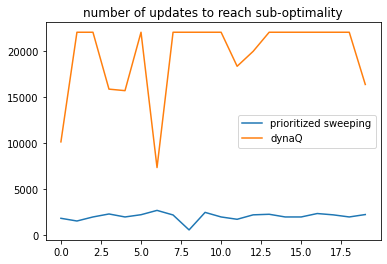

In [437]:
# plt.plot(avg_p, label="prioritized sweeping", color="blue")
# plt.plot(avg, label="dynaQ", color="orange")

plt.plot(updates_p, label="prioritized sweeping")
plt.plot(updates, label="dynaQ")
plt.title("number of updates to reach sub-optimality")
plt.legend()


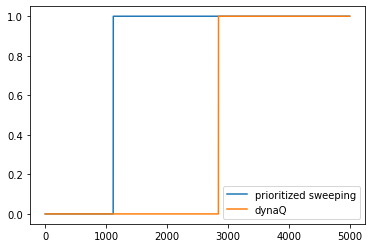

In [378]:
plt.plot(evals_p, label="prioritized sweeping")
plt.plot(evals, label="dynaQ")
plt.legend()


In [279]:
env_e = MazeEnv(blocks = SHORTCUT_PATTERN_1, start=(0,3))

In [414]:
evaluate(env_e, qcontrol.Q, limit=17)

True

In [409]:
def evaluate(env_, Q, limit = 20):
    state = tuple(env_.reset()[0])
    for i in range(limit):

        state, r,done,_,_ = env_.step(np.argmax(Q[state]))
        state= tuple(state)
        
        if done:
            return True
        
    return False
        
    

In [247]:
def compare(item1, item2):
    return item1[0] < item2[0]


q = queue.PriorityQueue()


In [46]:
hash

<function hash(obj, /)>

In [47]:
a = (1,2)
b = (3,54)
c = (5,3)

In [49]:
HASH_TO_STATE = {
    
}

In [50]:
HASH_TO_STATE[hash(a)] = a
HASH_TO_STATE[hash(b)] = b

In [73]:
q.put((1, "Jones"))

In [422]:
q.put( (0.9999999999, hash(b)) )

In [80]:
v= q.get()

In [81]:
v

(0.9999999999, -2627504400816755756)

In [84]:
HASH_TO_STATE[v[1]+23]

KeyError: -2627504400816755733

In [312]:
np.array([True,True,True]).all() == True

True

In [423]:
q._remove_existing_item(hash(b) )

AttributeError: 'PriorityQueue' object has no attribute '_remove_existing_item'

In [432]:
if not q.empty():
    print(q.get())

In [429]:
q.put( (1.9999999999, hash(b)) )